# Human Pose Estimation(2D)

**tf-pose-estimation**<br>

Developed after the Tensorflow implementation of OpenPose by [Ildoo Kim](https://github.com/ildoonet) : [tf-pose-estimation](https://github.com/ildoonet/tf-pose-estimation)

Original Openpose Repo(Caffe) : https://github.com/CMU-Perceptual-Computing-Lab/openpose

## Import Libraries

In [1]:
import warnings
# warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')

In [2]:
import os
import sys
import time
import logging
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tf_pose import common
from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path, model_wh
from scripts.custom_functions import plot_img , get_human_pose, show_heatmap, show_vectormaps, show_keypoints

In [3]:
%matplotlib inline

## Logger Initialization

In [4]:
logger = logging.getLogger('TfPoseEstimatorRun')
logger.handlers.clear()
logger.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('[%(asctime)s] [%(name)s] [%(levelname)s] %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)

## Model and TfPose Estimator

In [1]:
model='mobilenet_thin'
resize='432x368'
w, h = model_wh(resize)
if w == 0 or h == 0:
    e = TfPoseEstimator(get_graph_path(model), target_size=(432, 368))
else:
    e = TfPoseEstimator(get_graph_path(model), target_size=(w, h))

## Analysing heatmap and vectormap

In [8]:
# ls images

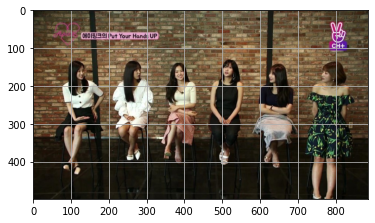

In [188]:
image_path = './images/apink3.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.grid();

In [189]:
image.shape

(499, 886, 3)

In [190]:
image = common.read_imgfile(image_path, None, None)

In [192]:
humans = e.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=4.0)

In [194]:
# e.heatMat[0][0]
e.heatMat.shape

(184, 216, 19)

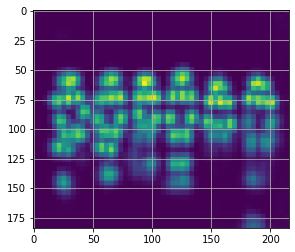

In [196]:
max_prob = np.amax(e.heatMat[:, :, :-1], axis=2)

plt.imshow(max_prob)
plt.grid();

In [298]:
# plt.figure(figsize=(15,8))
# bgimg = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_BGR2RGB)
# bgimg = cv2.resize(bgimg, (e.heatMat.shape[1], e.heatMat.shape[0]), interpolation=cv2.INTER_AREA)
# plt.imshow(bgimg, alpha=0.5)
# plt.imshow(max_prob, alpha=0.5)
# plt.colorbar()
# plt.grid();

In [274]:
# e.pafMat.shape
# e.pafMat.transpose((2, 0, 1)).shape
# e.pafMat.transpose((2, 0, 1))[::2, :, :].shape

(19, 184, 216)

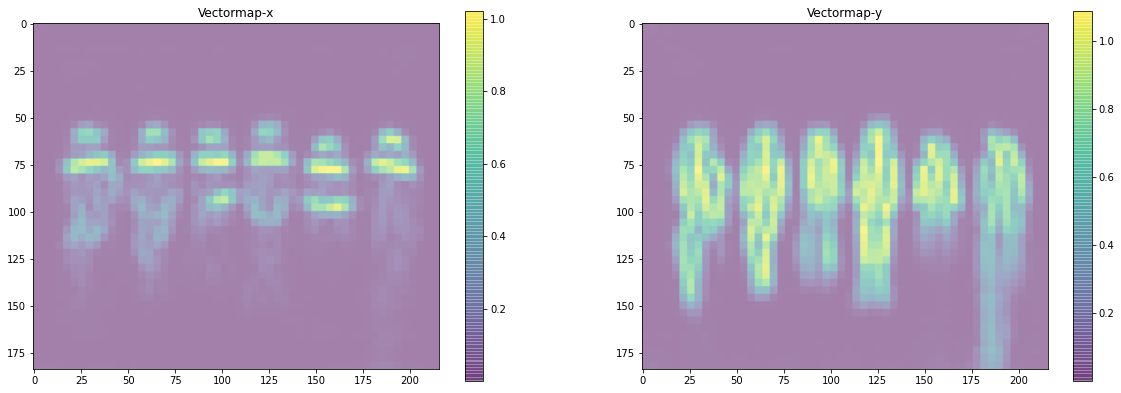

In [198]:
tmp2 = e.pafMat.transpose((2, 0, 1))
tmp2_odd = np.amax(np.absolute(tmp2[::2, :, :]), axis=0)
tmp2_even = np.amax(np.absolute(tmp2[1::2, :, :]), axis=0)

fig = plt.figure(figsize=(20,15))

a = fig.add_subplot(2, 2, 3)
a.set_title('Vectormap-x')
plt.imshow(tmp2_odd, alpha=0.5)
plt.colorbar()

a = fig.add_subplot(2, 2, 4)
a.set_title('Vectormap-y')
plt.imshow(tmp2_even, alpha=0.5)
plt.colorbar()
plt.show()

### Drawing_humans skeleton

In [199]:
image = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)

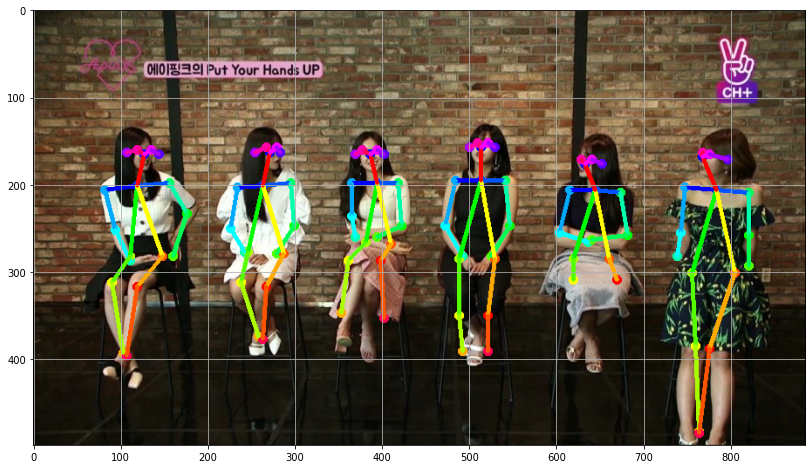

In [200]:
plot_img(image, axis=True, grid=True)

### Drawing only Skeleton

2020-12-28 15:29:05,816 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 885.5, 498.5, -0.5)

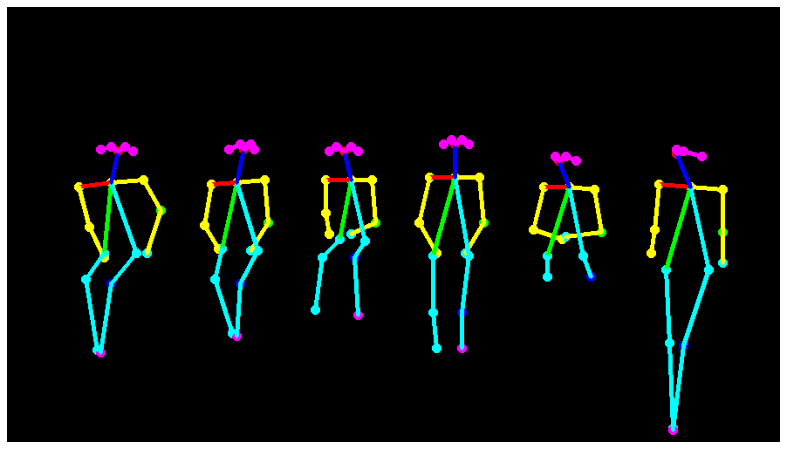

In [271]:
black_background = np.zeros(image.shape)
black_background_image=TfPoseEstimator.draw_humans(black_background, humans, imgcopy=False)
plt.figure(figsize=(15,8))
plt.imshow(black_background_image)
plt.axis('off')

## Getting the Keypoints (Joints) coordinates 

In [281]:
keypoints = str(str(str(humans[0]).split('BodyPart:')[1:]).split('-')).split(' score=')
len(keypoints)
keypoints_list=[]
for i in range (len(keypoints)-1): 
    pnt = keypoints[i][-11:-1]
    pnt = tuple(map(float, pnt.split(', ')))
    keypoints_list.append(pnt)

# Changing List to Array    
keypts_array = np.array(keypoints_list)
keypts_array = keypts_array*(image.shape[1],image.shape[0])
keypts_array = keypts_array.astype(int)


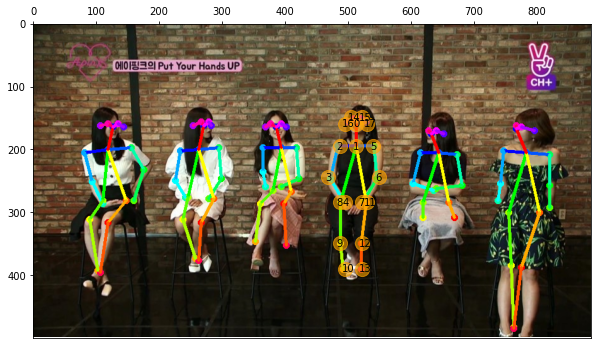

In [296]:
plt.figure(figsize=(10,10))
plt.axis([0, image.shape[1], 0, image.shape[0]])  
plt.scatter(*zip(*keypts_array), s=200, color='orange', alpha=0.6)
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(img)
ax=plt.gca() 
ax.set_ylim(ax.get_ylim()[::-1]) 
ax.xaxis.tick_top() 
# plt.grid();

for i, txt in enumerate(keypts_array):
    ax.annotate(i, (keypts_array[i][0]-5, keypts_array[i][1]+5))

### Using custom Functions

In [272]:
# # image_path = './images/human.png'
# img, hum = get_human_pose(image_path,e,showBG = True)
# plot_img(img, axis=True, grid=True)

#### Drawing keypoints with number

In [297]:
# image_path = './images/human.png'
# img, hum = get_human_pose(image_path,e, showBG=True)
# keypoints = show_keypoints(img, hum, showBG=True,color='white',human=2)

#### Drawing Face and Upper Body Bounding box

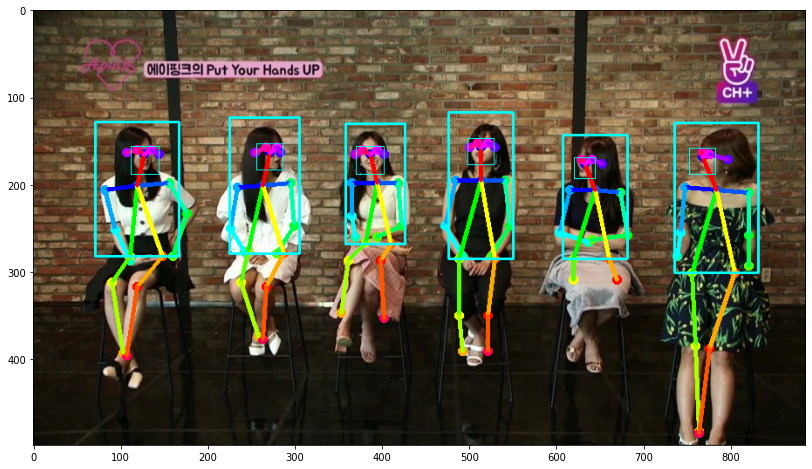

In [311]:
image_cp=image.copy()
image_cp=cv2.cvtColor(image_cp,cv2.COLOR_BGR2RGB)
for human in humans:
    face_cord=human.get_face_box(img_w=image.shape[1], img_h=image.shape[0])
    body_cord=human.get_upper_body_box(img_w=886, img_h=499)
    image_cp=cv2.rectangle(image_cp,(face_cord['x']-face_cord['w']//2,face_cord['y']-face_cord['h']//2),(face_cord['x']+face_cord['w']//2,face_cord['y']+face_cord['h']//2),[0,255,255],1)
    image_cp=cv2.rectangle(image_cp,(body_cord['x']-body_cord['w']//2,body_cord['y']-body_cord['h']//2),(body_cord['x']+body_cord['w']//2,body_cord['y']+body_cord['h']//2),[0,255,255],2)
plt.figure(figsize=( 15,8))
plt.imshow(image_cp)

### Plotting Scatter plot for observatoin

In [285]:
humans_keypoints=[]
for human in humans:
    
    keypoints = str(str(str(human).split('BodyPart:')[1:]).split('-')).split(' score=')
    len(keypoints)
    keypoints_list=[]
    for i in range (len(keypoints)-1): 
        pnt = keypoints[i][-11:-1]
        pnt = tuple(map(float, pnt.split(', ')))
        keypoints_list.append(pnt)

    # Changing List to Array    
    keypts_array = np.array(keypoints_list)
    keypts_array = keypts_array*(image.shape[1],image.shape[0])
    keypts_array = keypts_array.astype(int)
    humans_keypoints.append(keypts_array)

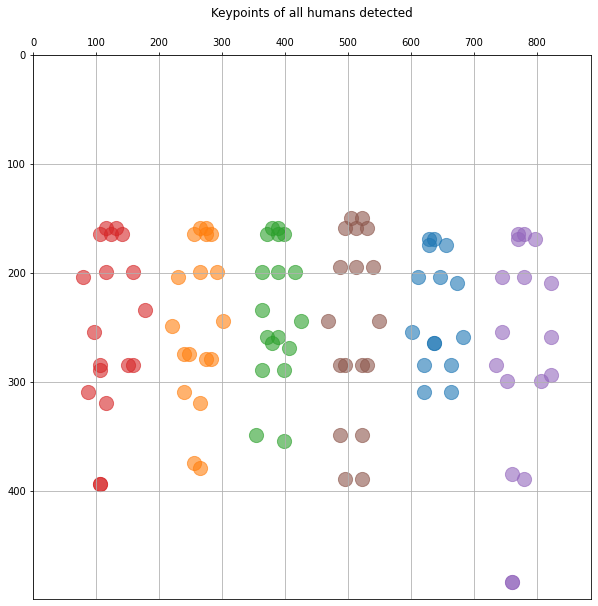

In [291]:
plt.figure(figsize=(10,10))
plt.axis([0, image.shape[1], 0, image.shape[0]])
# Add more color values for more than one person
colors= ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for idx, human_keypoints in enumerate(humans_keypoints):
    plt.scatter(*zip(*human_keypoints), s=200, color=colors[idx], alpha=0.6)
ax=plt.gca() 
ax.set_ylim(ax.get_ylim()[::-1]) 
ax.xaxis.tick_top() 
plt.title('Keypoints of all humans detected\n')
plt.grid();

### Showing Heatmap and Vector Map along with original image

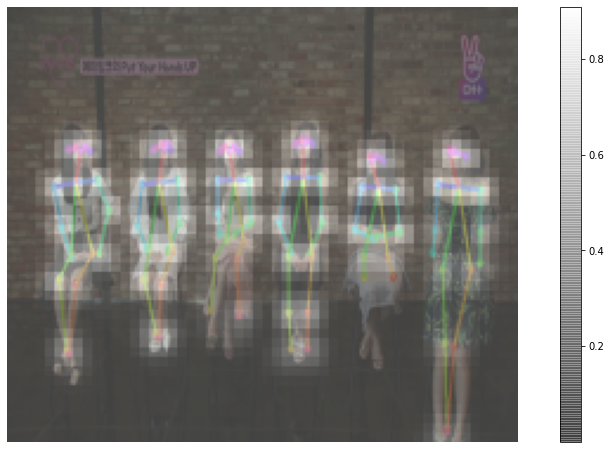

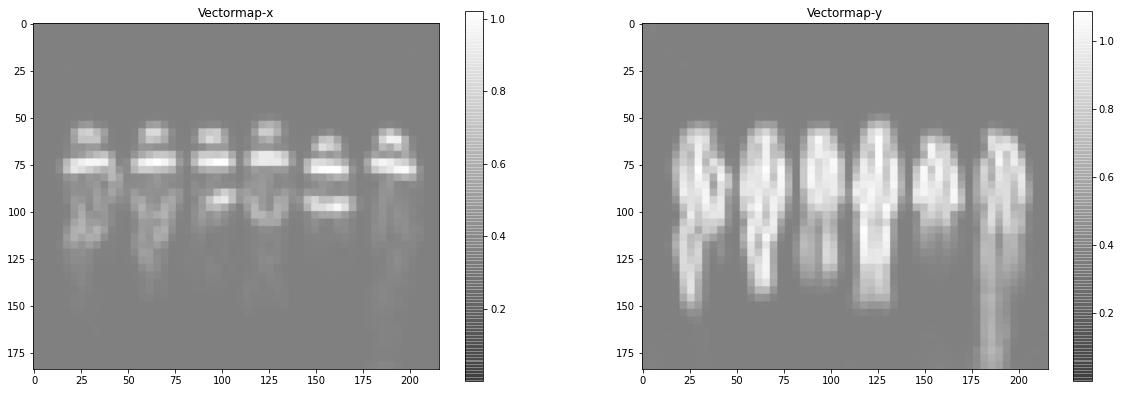

In [294]:
# image_path = './images/ski.jpg'
img, hum = get_human_pose(image_path,e)
show_heatmap(img,e)
show_vectormaps(img,e)

## Pose / Action classification using Openpose with Mobilenet and Inception

#### MobileNet is used for pose calssification on top of OpenPose(Sitting/Upright)
#### Inception is used for calssifying 40 day to day action on top of OpenPose ( Inception Network is trained on Stanford 40 dataset)

In [4]:
import scripts.label_image as label_img
import scripts.label_image_scene as label_img_scene

In [6]:
# model='mobilenet_thin'
# resize='432x368'
# w, h = model_wh(resize)
# if w == 0 or h == 0:
#     e = TfPoseEstimator(get_graph_path(model), target_size=(432, 368))
# else:
#     e = TfPoseEstimator(get_graph_path(model), target_size=(w, h))

In [61]:
image_path = './images/riding-bike.jpg'
original_image = common.read_imgfile(image_path, None, None)
image=original_image.copy()
humans = e.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=4.0)

In [62]:
# black_background = np.zeros(image.shape)
image = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)

In [63]:
#Getting full body co-ordinate for number of humans detected
humans_full_body=[]
for human in humans:
    full_body={}
    body_cord=human.get_upper_body_box(img_w=image.shape[1], img_h=image.shape[0])
    if body_cord==None:
        continue
    x1=int(body_cord['x']-body_cord['w']//1.1)
    y1=int(body_cord['y']-body_cord['h']//1.5)
    x2=int(body_cord['x']+body_cord['w']//1.1)
    y2=int(body_cord['y']+body_cord['h']*2)
    # Comparing so that the co-ordinate doesnot go out of bound
    x1=max(x1,0)
    y1=max(y1,0)
    x2=min(x2,image.shape[1]-2)
    y2=min(y2,image.shape[0]-2)
    full_body['x1']=x1
    full_body['y1']=y1
    full_body['x2']=x2
    full_body['y2']=y2
    humans_full_body.append(full_body)
    
# Classifying pose for evaery person detected and getting pose only from pose & score and counting the number of poses in image
pose_classes=[]
pose_list=[]
for human_full_body in humans_full_body:
    human_image = image[human_full_body['y1']:human_full_body['y2'],human_full_body['x1']:human_full_body['x2']]
    pose_class = label_img.classify(human_image)
    pose_classes.append(pose_class)
for pose_class in pose_classes:
    pose_list.append(pose_class.split()[0])
    
sitting_num=pose_list.count('sitting')
upright_num=pose_list.count('standing')


Evaluation time (1-image): 1.731s



In [567]:
# # Displaying person detected according to bounding box 
# plt.figure(figsize=(10,8))
# plt.imshow(image[humans_full_body[0]['y1']:humans_full_body[0]['y2'],humans_full_body[0]['x1']:humans_full_body[0]['x2']])

In [568]:
###Displaying bounding boxes for every person detected
# image_cp=image.copy()
# for idx,human_full_body in enumerate(humans_full_body):
#     cv2.rectangle(image_cp,(human_full_body['x1'],human_full_body['y1']),(human_full_body['x2'],human_full_body['y2']),[0,255,255],2)
#     cv2.putText(image_cp,f'{idx}', (human_full_body['x1']+10,human_full_body['y1']+20),  cv2.FONT_HERSHEY_SIMPLEX, 0.8,(255, 0, 0), 2)
# plt.figure(figsize=( 15,8))
# plt.imshow(image_cp)

In [65]:

if len(humans)==1:
    scene_class = label_img_scene.classify(image_path)
# end_time = time.time()
logger.debug('+displaying+')
cv2.putText(image,
            f'Standing:{upright_num} Sitting:{sitting_num}',
            (10, 15),  cv2.FONT_HERSHEY_SIMPLEX, 0.6,
            (0, 0, 255), 2)
if len(humans)==1:
    cv2.putText(image,
            "Predicted Scene: %s" %(scene_class),
            (10, 40),  cv2.FONT_HERSHEY_SIMPLEX, 0.7,
            (0, 0, 255), 2)
# print('\n Overall Evaluation time (1-image): {:.3f}s\n'.format(end_time-start_time))
cv2.imwrite('show1.png',image)
cv2.imshow('tf-human-action-classification result', image)
cv2.waitKey(0)
logger.debug('+finished+')
cv2.destroyAllWindows()

[2020-12-29 13:47:11,109] [TfPoseEstimatorRun] [DEBUG] +displaying+
2020-12-29 13:47:11,109 DEBUG +displaying+



Evaluation time (1-image): 1.242s

riding a bike (score=0.97532)
fixing a bike (score=0.01670)
running (score=0.00436)
jumping (score=0.00052)
walking the dog (score=0.00048)


[2020-12-29 13:47:32,586] [TfPoseEstimatorRun] [DEBUG] +finished+
2020-12-29 13:47:32,586 DEBUG +finished+


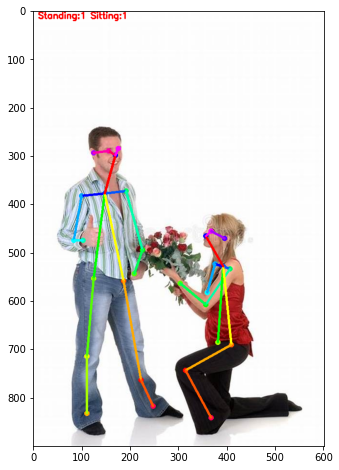

In [549]:
plt.figure(figsize=(15,8))
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

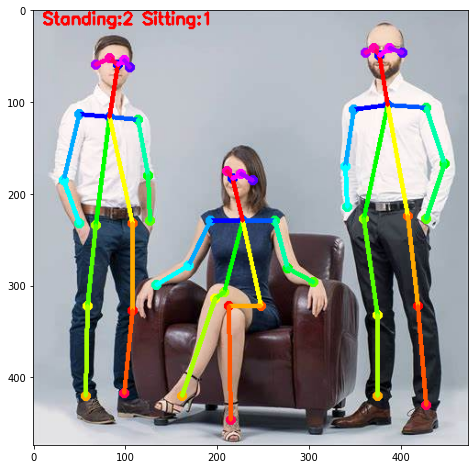

In [554]:
plt.figure(figsize=(15,8))
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

#### Classifying scene along with pose

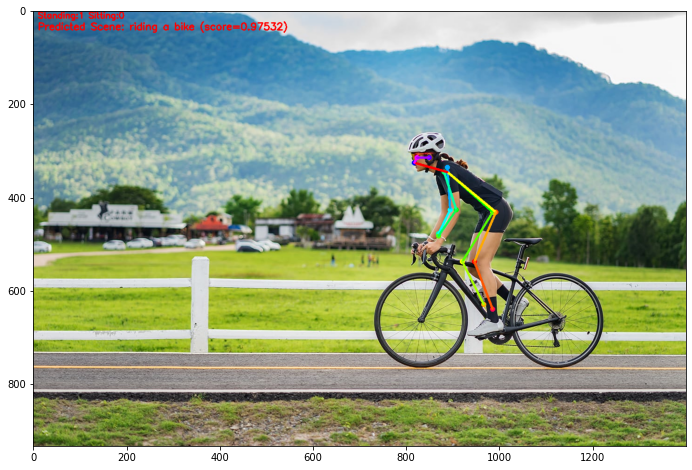

In [48]:
plt.figure(figsize=(15,8))
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

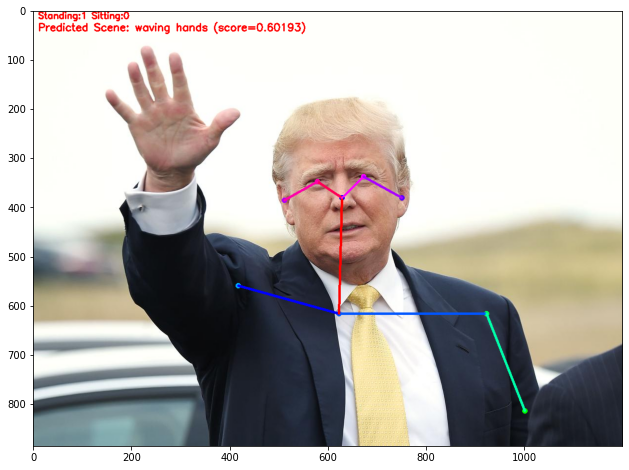

In [54]:
plt.figure(figsize=(15,8))
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

## Fall Detection in Video using OpenPose as base

In [7]:
# model='mobilenet_thin'
# resize='432x368'
# w, h = model_wh(resize)
# e = TfPoseEstimator(get_graph_path(model), target_size=(w, h))

In [8]:
video_path = './videos/fall_short.mp4'
showBG = True # False to show skeleton only.

In [9]:
file_write_name,_ = os.path.splitext(video_path)

In [10]:
cap = cv2.VideoCapture(video_path)
if cap.isOpened() is False:
    print("Error opening video stream or file")

In [11]:
count = 0
fall_count=0
y1 = [0,0,0,0]
frame = 0
fps_time = 0
new_fall=True
frame_to_ignore=0
while True:
    ret_val, image = cap.read()
    i =1
    count+=1
    if not ret_val:
        break
    

    humans = e.inference(image,
                         resize_to_default=(w > 0 and h > 0),
                         upsample_size=4.0)
    if not showBG:
        image = np.zeros(image.shape)
    image = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)
        
    for human in humans:
        # we select one person from num of person
        for i in range(len(humans)):
            try:
                #human.parts contains all the detected body parts
                a = human.body_parts[0]   # human.body_parts[0] is for head point coordinates
                x = a.x*image.shape[1]   # x coordinate relative to image 
                y = a.y*image.shape[0]   # y coordinate relative to image
                y1.append(y)   # store value of y coordinate in list to compare two frames
            except:
                pass
            if count > 4: #Ignoring first few frames
                                
                cv2.putText(image, f"Fall Detected Count: {fall_count}", (20,50), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0,0,255), 
                        2, 11)
                #cv2.putText(image, f'{fall_count}', (20,80), cv2.FONT_HERSHEY_COMPLEX, 1.1, (0,0,255),2, 11)
                if ((y - y1[-2]) > 25) and (new_fall==True) :  # it's distance between frame and comparing it with thresold value
                    new_fall=False
                    frame_to_ignore=count+24
                    fall_count+=1
                    #cv2.putText(image, f'{fall_count}', (30,60), cv2.FONT_HERSHEY_COMPLEX, 1.5, (0,0,255), 
                    #    2, 11)
                    print("fall detected.",i+1, count)#You can set count for get that your detection is working
                if count == frame_to_ignore:
                    new_fall=True
                    
    

    cv2.putText(image, "FPS: %f" % (1.0 / (time.time() - fps_time)), (10, 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
#     cv2.imshow('tf-pose-estimation result', image)
    fps_time = time.time()
    if frame == 0:   # It's use to intialize video writer ones
        out = cv2.VideoWriter(file_write_name+'_output.avi',cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'),
                20,(image.shape[1],image.shape[0]))
        frame+=1
    out.write(image)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()
print("The video was successfully saved")
#logger.debug('finished+')


fall detected. 1 40
fall detected. 1 153
fall detected. 1 278
fall detected. 1 421
The video was successfully saved


## Demo video : 
##### https://drive.google.com/file/d/1Gj6vOotU0yoSDl0LEP7ctp3uWmy19Oln/view?usp=sharing

## To Do:
- Multi-person tracking and fall detection 
- Increase accuracy of pose classification